In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
# def variable
from torch.autograd import Variable

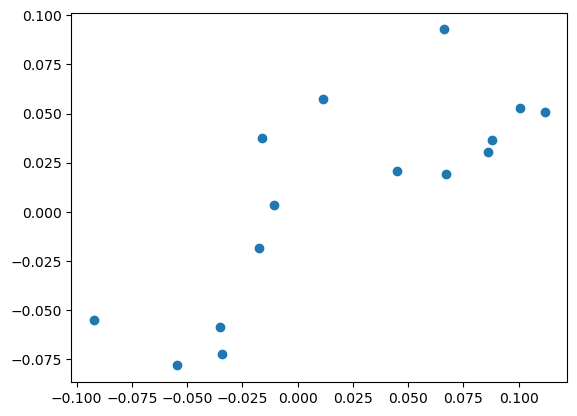

In [2]:
from src.models import LVGEBM
model = LVGEBM(15,4,10000)
y = model(model.z)
# plot y
y = y.detach().numpy()
plt.scatter(y[:,0],y[:,1])

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading data...
Data loaded.
[100.         290.           1.           0.35545887]


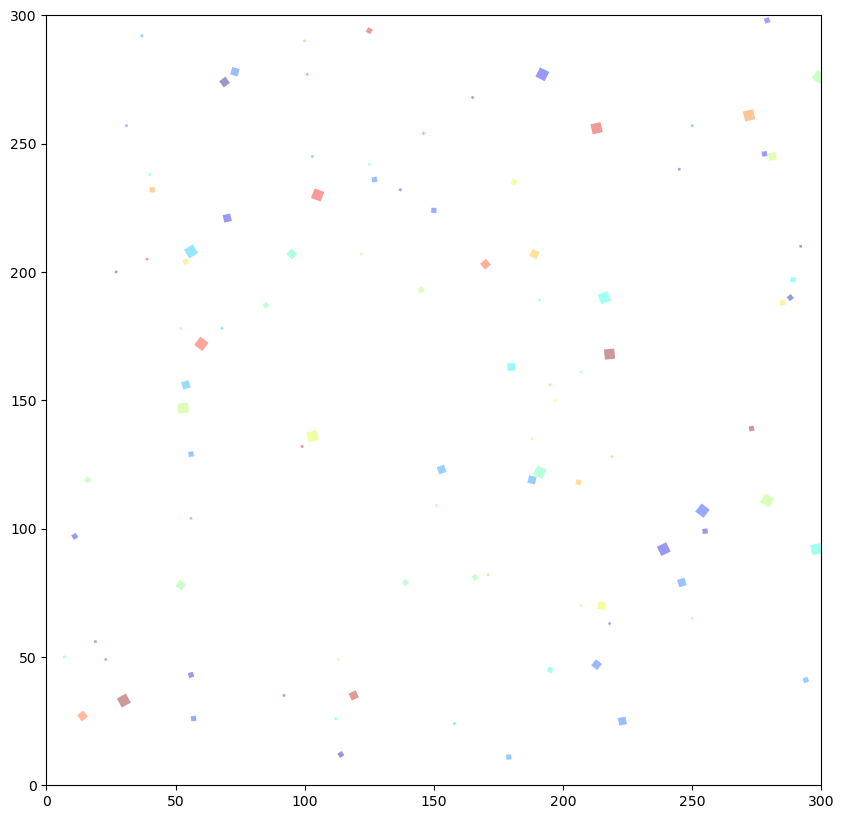

In [4]:
from src.utils.data import loadData

# load data
sq, qp = loadData(100)
print(sq[0])
from src import visualization as vis
vis.plot_data(sq,limits=[0,300,0,300])

In [5]:
from src.metrics import Linf
from src.ebmUtils import Reg, RegLatent, loss_functional

In [6]:
from src.train import trainTeacher

In [7]:
model = LVGEBM(4,2,400).to(device)
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 200
times = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_data = torch.from_numpy(sq).float().to(device)
alpha = 5
beta = 10
results = trainTeacher(model
                          , optimizer
                          , epochs
                          , times
                          , device
                          , train_data
                          , alpha
                          , beta
)

Training Teacher Model
Epoch: 20/200..  Training loss: 6881.99268..  Reg Proj: 0.00000..  Reg Latent: 4.75579..  Memory: 6834.43457..  Cost: 6881.99268.. 
Epoch: 40/200..  Training loss: 8266.87891..  Reg Proj: 0.00000..  Reg Latent: 2.11525..  Memory: 8245.72656..  Cost: 8266.87891.. 
Epoch: 60/200..  Training loss: 7487.84619..  Reg Proj: 0.00000..  Reg Latent: 2.57153..  Memory: 7462.13086..  Cost: 7487.84619.. 
Epoch: 80/200..  Training loss: 8074.89990..  Reg Proj: 0.00000..  Reg Latent: 2.01377..  Memory: 8054.76221..  Cost: 8074.89990.. 
Epoch: 100/200..  Training loss: 6952.50488..  Reg Proj: 0.00000..  Reg Latent: 1.66945..  Memory: 6935.81055..  Cost: 6952.50488.. 
Epoch: 120/200..  Training loss: 7069.12061..  Reg Proj: 0.00000..  Reg Latent: 2.98602..  Memory: 7039.26025..  Cost: 7069.12061.. 
Epoch: 140/200..  Training loss: 8602.28223..  Reg Proj: 0.00000..  Reg Latent: 2.81425..  Memory: 8574.13965..  Cost: 8602.28223.. 
Epoch: 160/200..  Training loss: 8435.03809..  Reg

best epoch:  134
best outputs:  tensor([[ 86.3245, 207.5733],
        [253.3601, 232.0096],
        [168.3385, 141.5613],
        [135.0126,  32.8206]], device='cuda:0', grad_fn=<AddBackward0>)
costs:  [20025.556640625, 19958.05859375, 32368.072265625, 19828.328125, 22793.291015625, 19443.67578125, 13521.5498046875, 18421.75390625, 29045.115234375, 16933.33203125, 19503.576171875, 14592.8408203125, 16355.61328125, 10855.7705078125, 9790.5244140625, 7427.15625, 6620.255859375, 6856.34619140625, 8549.267578125, 6881.99267578125, 7280.107421875, 6786.70068359375, 9913.5322265625, 6849.5439453125, 5970.8037109375, 6742.39599609375, 6671.15478515625, 6829.01513671875, 6569.46533203125, 6920.5966796875, 6506.45947265625, 6795.095703125, 7106.47216796875, 7031.58349609375, 6105.40869140625, 8142.98291015625, 7250.23681640625, 8312.4853515625, 6525.42529296875, 8266.87890625, 7440.0859375, 8972.4013671875, 8645.4208984375, 9797.2138671875, 9444.4384765625, 9401.3212890625, 7829.421875, 8918.09

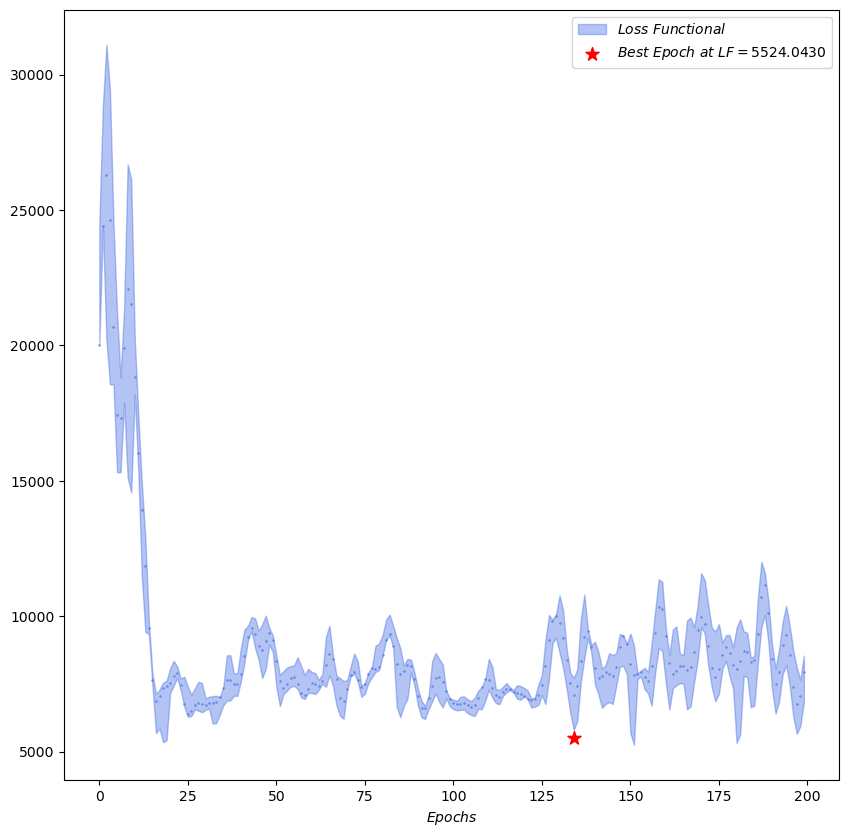

In [8]:
from src.utils.plot_tools import plot_AM_dem, AM_dem
best_outputs = results["best_outputs"]
best_epoch = results["best_epoch"]
costs = results["cost_array"]
print("best epoch: ", best_epoch)
print("best outputs: ", best_outputs)
print("costs: ", costs)
signal = costs
upper_signal, lower_signal, filtered_siganl = AM_dem(signal, fc=0.4*len(signal),fs=2*len(signal))
plot_AM_dem(upper_signal, lower_signal, filtered_siganl, signal, best_epoch)

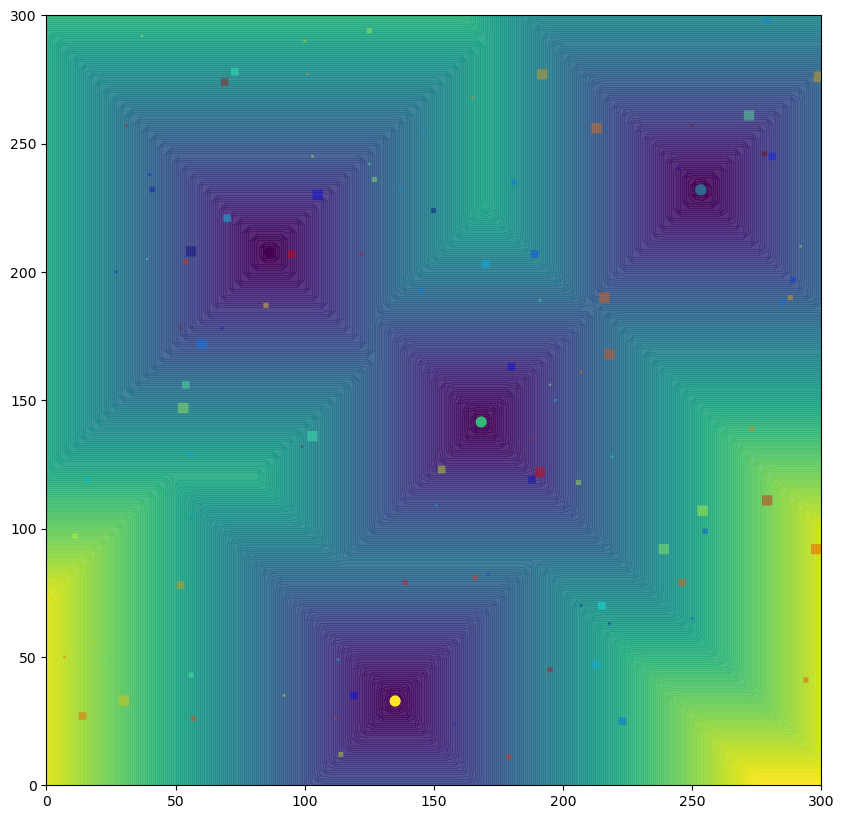

In [10]:
from src.utils import plot_tools as pt
manifold = pt.createManifold(model, best_outputs.cpu())
manifold1 = manifold
pt.plotManifold(sq, manifold, best_outputs.cpu(),[0,300],[0,300])

## Till here done

In [211]:
class Voronoi(nn.Module):
    def __init__(self, n_centroids, input_dim, output_dim):
        super(Voronoi, self).__init__()
        self.n_centroids = n_centroids
        self.input_dim = input_dim
        self.output_dim = output_dim
        # inputs are datapoints and outputs are energies
        self.predictor = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, n_centroids)

        )

    def forward(self, x):
        x = self.predictor(x)
        return x
        
vor = Voronoi(10, 2, 2)
x = qp[0:3]
print(x.shape)
x = torch.tensor(x, dtype=torch.float32)
y = vor(x)
print(y.shape)

torch.Size([3, 2])


C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\1264129564.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [13]:
from src.models import  Voronoi


vor = Voronoi(10, 2, 2)
y_ = vor(x)
print(y_.shape)

torch.Size([3, 10])


In [12]:
torchsummary.summary(best_model)

NameError: name 'torchsummary' is not defined

In [19]:
# permute qp
qp = np.random.permutation(qp)
qp = qp[:200]
qp = torch.tensor(qp)
def getE(model, best_outputs, qp):
    # get qp
    qp = torch.tensor(qp)
    # get outputs
    outputs = best_outputs
    outputs = torch.tensor(outputs)
    # make Linf between outputs points and qp (between them all)
    E = torch.zeros(outputs.shape[0], qp.shape[0])
    for i in range(outputs.shape[0]):
        for j in range(qp.shape[0]):
            E[i,j] = torch.max(torch.abs(outputs[i] - qp[j]))
    F, z = E.min(0)
    # now do the same for sq
    outputs = outputs.detach().numpy()
    sq_, _ = loadData(100)
    E_sq = loss_functional(outputs, sq_, model)
    F_sq, z_sq = E_sq.min(1)
    
    return F, z, F_sq, z_sq

def NearestNeighbour(qp, sq):
    d_nn = np.inf
    z_nn = 0
    for i, square in enumerate(sq):
        d_nn_sq,_,_ = Linf(square, qp)
        if d_nn_sq <= d_nn:
            d_nn = d_nn_sq
            z_nn = i
    return d_nn, z_nn

def Accuracy(F, z, F_sq, z_sq, qp, sq):
    acc = 0
    for i in range(qp.shape[0]):
        # find nn of qp[i]
        d_nn, z_nn = NearestNeighbour(qp[i], sq)
        
        #print("d_nn: ", d_nn)
        #print("z_nn: ", z_nn)
        #print("z[i]: ", z[i])
        #print("z_sq[z_nn]: ", z_sq[z_nn])
        if z_sq[z_nn] == z[i]:
            acc += 1
    return acc/qp.shape[0]
best_model = results["best_model"].cpu()
best_outputs = results["best_outputs"].cpu()
F, z, F_sq, z_sq = getE(best_model,best_outputs, qp)


Loading data...
Data loaded.


C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\897909319.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp)
C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\897909319.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs)


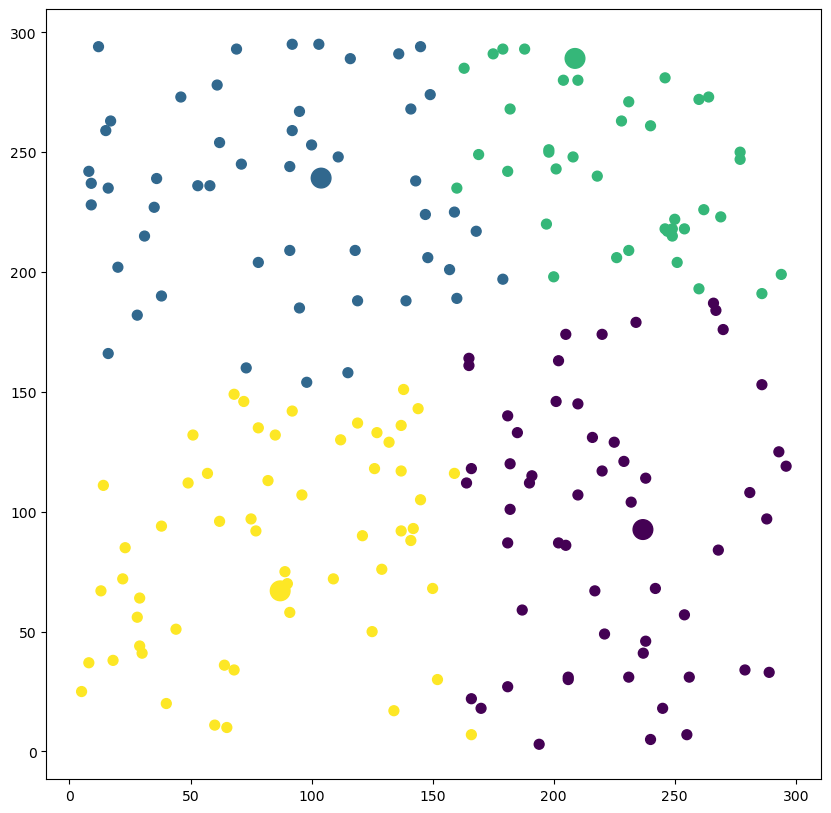

In [23]:
#plot qp
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#labels are z
labels = z.cpu().detach().numpy()
plt_qp = qp.cpu().detach().numpy()
ax.scatter(plt_qp[:,0], plt_qp[:,1], c=labels, s=50)
# plot best_outputs
plt_bo = best_outputs
plt_bo = plt_bo.cpu().detach().numpy()
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:,0], plt_bo[:,1], c=c, s=200)
z_labels = z
#plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

## DIST

In [224]:
vor = Voronoi(4, 2, 2).to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [229]:
plt_qp[0]

array([122., 292.], dtype=float32)

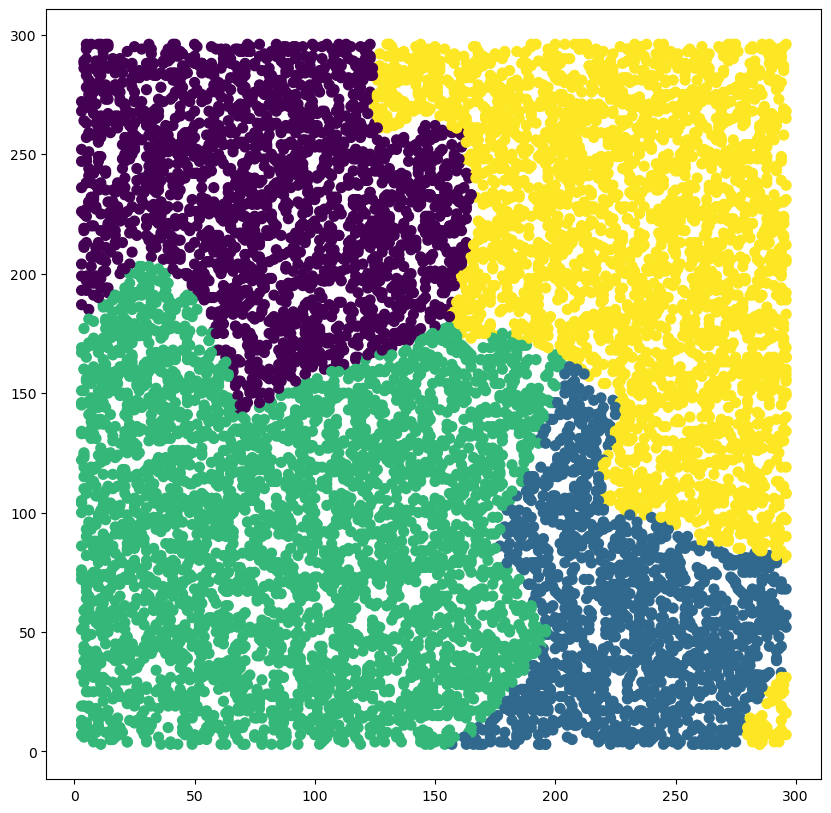

In [230]:
# plot qp
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#labels are z
labels = z.cpu().detach().numpy()
plt_qp = qp.cpu().detach().numpy()
ax.scatter(plt_qp[:,0], plt_qp[:,1], c=labels, s=50)

In [227]:

loss = nn.L1Loss()
_, qp = loadData(100)
qp = torch.tensor(qp)
optimizer = torch.optim.Adam(vor.parameters(), lr=1e-3)
epochs = 5000
squares, _ = loadData(100)
pseudo_clusters = []
n_centroids = 4
for i in range(n_centroids):
    # append squares that their z_sq is i
    pseudo_clusters.append(squares[z_sq==i])
F_l = []
z_l = []
cost_l = []
qp = torch.tensor(qp).to(device)
outputs = torch.zeros(qp.shape[0], n_centroids)
F_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
z_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
ce = nn.CrossEntropyLoss()
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        qpoint = qp[i].cpu().detach().numpy()
        F_ps[i,j], z_ps[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))
print("Training Voronoi")
for epoch in range(epochs):
    #qp = np.load('100qp.npy')
    # get 1000 random points from qp
    # shuffle data
    #qp = torch.tensor(qp)
    #qp = qp[torch.randperm(qp.shape[0])][:100]
    qp = torch.tensor(qp, dtype=torch.float32).to(device)
    # get outputs
    outputs = vor(qp)
    # get pseudo labels

    
    # pass outputs through a hard arg max
    F, z = outputs.min(1)
    F_ps_m, z_ps_m = F_ps.min(1)
    # send to device
    F_ps_m = F_ps_m.to(device)
    z_ps_m = z_ps_m.to(device)
    # clone to device
    #make values of z_ps_m to be round to nearest integer
    r_z = torch.round(z_ps_m)

    # get loss
    alpha = 100
    beta = 1000
    z = z.float()
    #bce_loss = nn.BCELoss()(z, z_ps_m)
    z_ = outputs
    # make z_ float
    z_ = z_.float()
    z_cost = ce(z_, z_ps_m)
    F_cost = loss(F, F_ps_m)
    # get z_cost where we only penalize the wrong z and not its distance
    #z_cost = penalty(z, r_z)
    #F_l.append(F_cost.item())
    z_l.append(z_cost.item())
    #cost = alpha*F_cost + beta*z_cost
    cost = 10*z_cost 
    cost_l.append(cost.item())
    # backward
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if epoch%1000 ==0:
        print("Epoch: ", epoch, "Cost: ", cost.item())
        # lets check acc
        acc = 0
        for i in range(qp.shape[0]):
            F_e, z_e = outputs[i].max(0)
            if z_e == z_ps_m[i]:
                acc += 1
        print("Acc: ", acc/qp.shape[0])

            


Loading data...
Data loaded.
Loading data...
Data loaded.


C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\2337599252.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp).to(device)


Training Voronoi
Epoch:  0 Cost:  35.531410217285156


C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\2337599252.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp, dtype=torch.float32).to(device)


Acc:  0.3279
Epoch:  1000 Cost:  1.8856873512268066
Acc:  0.9326
Epoch:  2000 Cost:  1.3333048820495605
Acc:  0.9367
Epoch:  3000 Cost:  0.8375027179718018
Acc:  0.967
Epoch:  4000 Cost:  1.16023850440979
Acc:  0.941


In [232]:
e = 10
x1 = outputs[e]
x2 = torch.tensor([[1]]).to(device)
x3 = z_ps_m[e]
print(f'x1: {x1}')
print(f'label is: {x3}')
for i in range(4):
    nu = i
    x4 = torch.tensor(nu).to(device)
    print(ce(x1,x4))

x1: tensor([ 22.6595, -14.0711,  -0.2719, -14.2612], device='cuda:0',
       grad_fn=<SelectBackward0>)
label is: 0
tensor(-0., device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(36.7306, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(22.9314, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(36.9207, device='cuda:0', grad_fn=<NllLossBackward0>)


In [31]:
def penalty(z_hat,z_target):
    loss = 0
    for i in range(z_hat.shape[0]):
        if z_hat[i] != z_target[i]:
            loss += 1
    return loss

(0.0, 200.0)

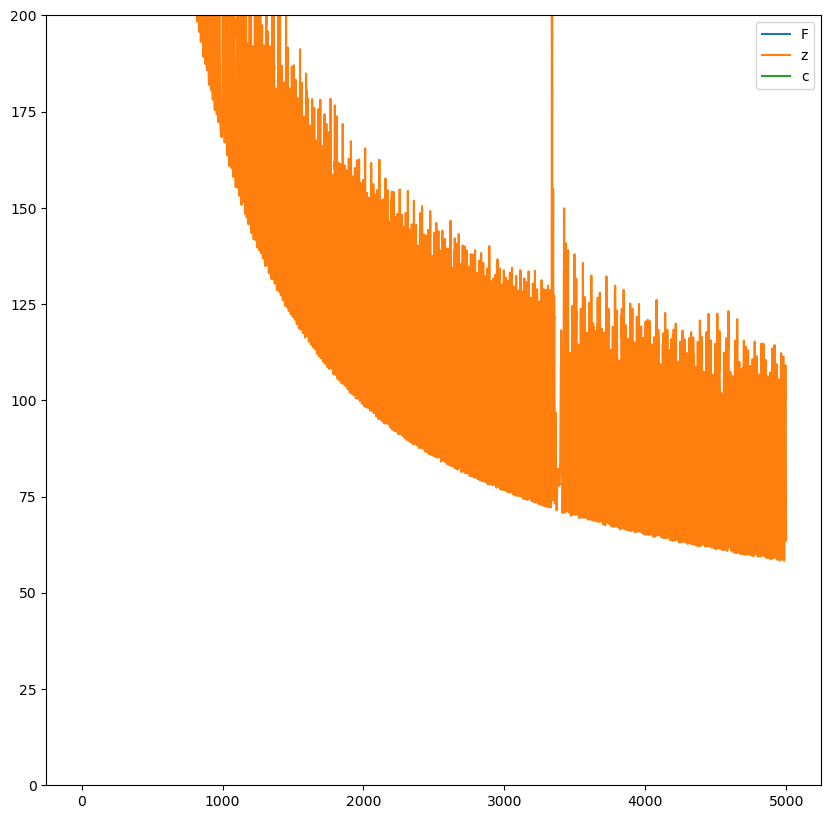

In [233]:
#print F_l and z_l

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(F_l, label='F')
z_l_p  = []
for i in range(len(z_l)):
    z_l_p.append(z_l[i]*beta)
ax.plot(z_l_p, label='z')
c_l = []
for i in range(len(F_l)):
    c_l.append(F_l[i]+beta*z_l[i])
ax.plot(c_l, label='c')
ax.legend()
# set ylim
ax.set_ylim([0,200])
#ax.set_xlim([-1,epochs])
#ax.set_ylim([0,100])

In [234]:
model = vor
# plot manifold
x_discr = 100
y_discr = 100
manifold = torch.zeros(x_discr, y_discr, 4)
x_lim = [0,300]
y_lim = [0,300]
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], x_discr)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], y_discr)):
        manifold[i, j, :] = torch.Tensor([x, y, 0,0])

print(manifold.shape)
# break manifold to batches of nx2
manifold = manifold.view(-1, 4) # 10000x3 take -> 10000x2 (drop 3rd dim)
points = manifold[:, :2]
# add 2 more columns to points and make them 0
#points = torch.cat((points, torch.zeros(points.shape[0], 2)), 1)
# send to device
points = points.to(device)
print(points.shape)# run through the network
#outputs = p_p[-2]
E = vor(points)
F, z = E.max(1)
print("outputs.shape", outputs.shape)
#cost = criterion(outputs, points) # 400x2 cdot 15x2
#points = points.detach().numpy()
for i in range(manifold.shape[0]):
    manifold[i,-2] = F[i]
    manifold[i,-1] = z[i]
# reshape to 100x100x3
manifold = manifold.reshape(100,100,4)

torch.Size([100, 100, 4])
torch.Size([10000, 2])
outputs.shape torch.Size([10000, 4])


In [ ]:
n = 500
print('points[n]: ',points[n])
print('E[n]: ', E[n])


In [ ]:
# import summary
import torchsummary
torchsummary.summary(best_model)

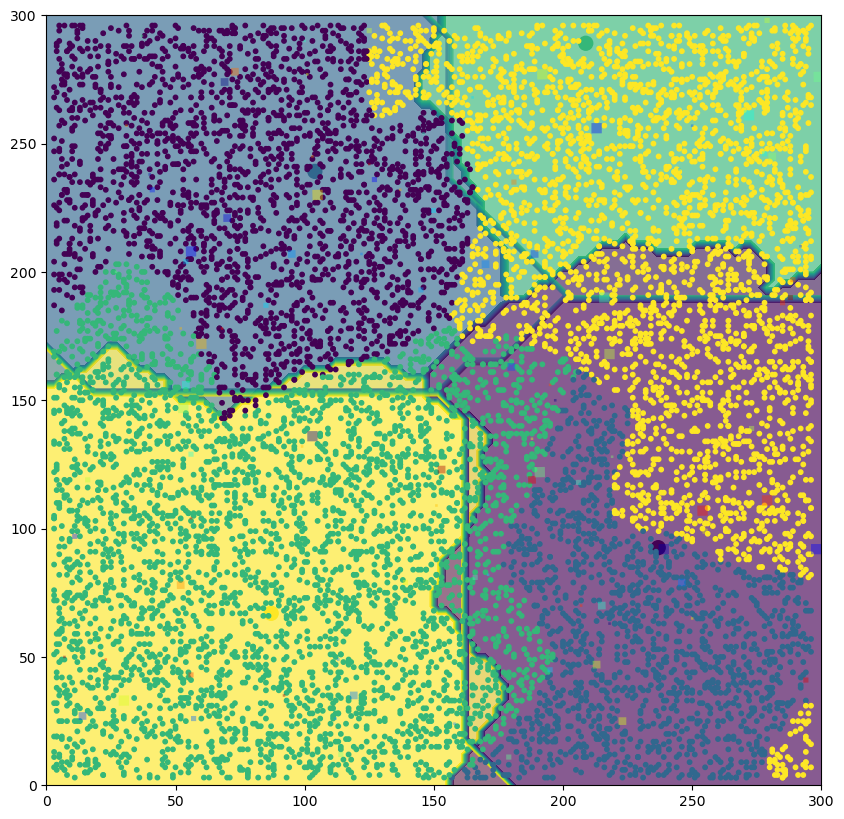

In [235]:
from matplotlib import cm
manifold_plot = manifold.cpu().detach().numpy()
# plot manifold as contour
fig = plt.figure(figsize=(10,10))

#make 3d plot
ax = fig.add_subplot(111)
# plot class
level = 200
ax.contourf(manifold_plot[:,:,0], manifold_plot[:,:,1], manifold_plot[:,:,-1], levels=level, cmap='viridis', alpha=0.6)
ax.contourf(manifold_plot[:,:,0], manifold_plot[:,:,1], manifold1[:,:,-1], levels=level, cmap='viridis', alpha=0.1)
# plot scatter of output = model(model.z)
o = best_outputs.cpu().detach().numpy()
# lb is 0,..,no
no = n_centroids
lb = np.linspace(0, no-1, no)
ax.scatter(o[:,0], o[:,1],c=lb, s=100)
# also plot qp
qp_p = qp.cpu().detach().numpy()
#labels = z.cpu().detach().numpy()
ax.scatter(qp_p[:,0], qp_p[:,1],c=labels, s=10)
# -1 is the noise
#no = n_centroids
#color = cm.coolwarm(np.linspace(0, 1, no))
#for i in range(no):
#    ax.scatter(qp_p[labels==i,0], qp_p[labels==i,1],c=color[i], s=10)
#ax.set_xlim([0,300])
#ax.set_ylim([0,300])
# also vis data
pt.plot_data_on_manifold(fig, ax, sq,size=10, limits=[0,300,0,300])
#plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

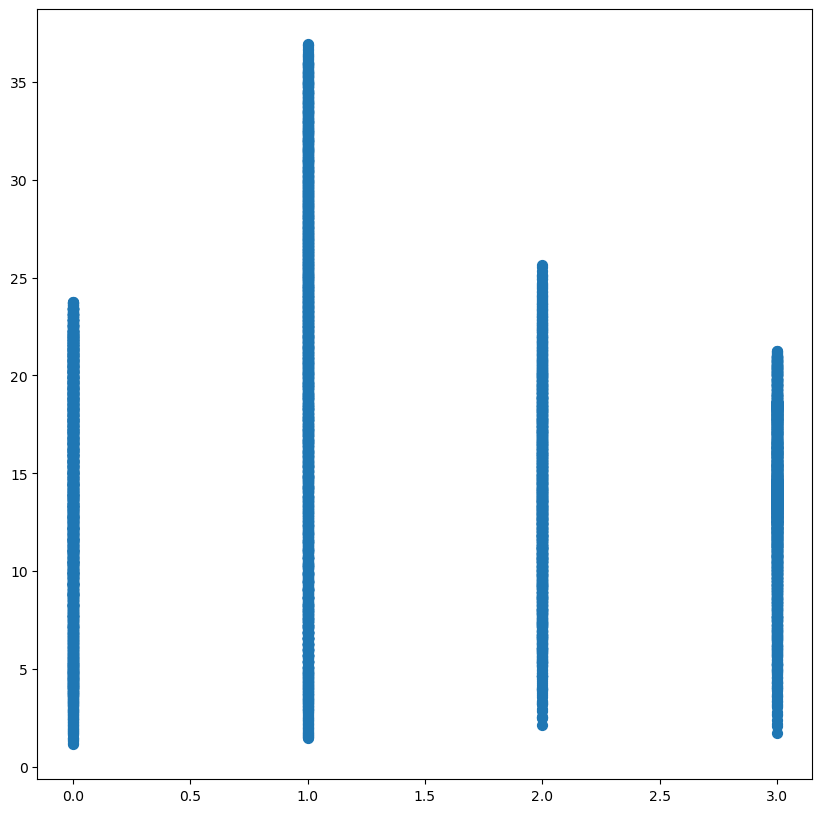

In [236]:
# show all z
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(z.cpu().detach().numpy(), F.cpu().detach().numpy(), s=50)

epsilon is 69.62712860107422
points sampled:  5156
manifold1[:,:,0]:  torch.Size([100, 100])
manifold1[:,:,1]:  torch.Size([100, 100])
manifold1[:,:,-2]:  torch.Size([100, 100])


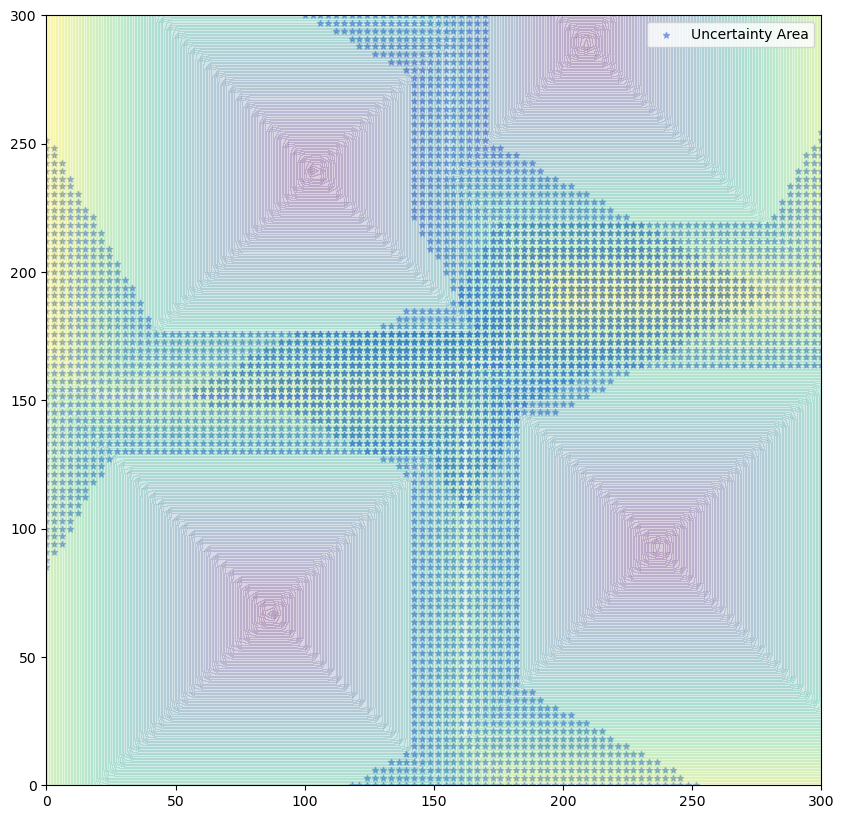

In [306]:
# will sample points on the voronoi edges
# we will label them and fine tune a student network
# the sampler will be a module or a function?
def getUncertaintyArea(outputs, N, M, epsilon, x_area, y_area, model):
    # first lets sample N points in the spaces defined by x_area and y_area
    n_points = torch.zeros(N**2, 2)
    x_p = np.linspace(x_area[0], x_area[1], N)
    y_p = np.linspace(y_area[0], y_area[1], N)
    for i in range(N**2):
        n_points[i] = torch.tensor([x_p[i%N], y_p[i//N]])
    # now lets get the uncertainty area for each point
    # we will use the epsilon ball
    n_points_cat = torch.cat((n_points, torch.zeros(n_points.shape[0], 2)), 1).detach().numpy()
    E = loss_functional(outputs, n_points_cat, model)
    # get the min distance
    m_points = []
    m = 0
    i = 0
    at = 1
    while m<=M:
        E1 = E[i]
        F1 = E1.min()
        # if there is another F s.t. abs(F-F1) <= epsilon => add point to n_points
        for j in range(E1.shape[0]):
            """
            print(f'point {j} of {E1.shape[0]}')
            print(f'point {m} of {M}')
            print(f'F1 is {F1}')
            print(f'E1 is {E1}')
            """
            diff = torch.abs(F1 - E1[j])
            #print(f'diff is {diff}')
            epsilon = F1*.8
            if at == 1:
                print(f'epsilon is {epsilon}')
                at = 0
            if diff <= epsilon and F1 != E1[j]:
                m_points.append(n_points[i])
                m += 1
                #print("New point added")
                continue
        i += 1
        if i == E.shape[0]:
            break
    
    return m_points 
n_p= getUncertaintyArea(best_outputs.cpu().detach().numpy(),100, 200*200, 10, [0,300], [0,300], model)
print('points sampled: ', n_p.__len__())
# plot n_p
n_p = np.array(n_p)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(n_p[:,0], n_p[:,1], s=20, c='royalblue', alpha=0.5, marker='*', label='Uncertainty Area')
ax.contourf(manifold1[:,:,0], manifold1[:,:,1], manifold1[:,:,-2], levels=level, cmap='viridis', alpha=0.2)
print('manifold1[:,:,0]: ', manifold1[:,:,0].shape)
print('manifold1[:,:,1]: ', manifold1[:,:,1].shape)
print('manifold1[:,:,-2]: ', manifold1[:,:,-2].shape)
plt.legend()

In [307]:
"""
qp = np.load('100qp.npy')
# permute qp
qp = np.random.permutation(qp)
qp = qp[:200]
qp = torch.tensor(qp)
"""
qp = n_p
qp = np.random.permutation(qp)
qp = torch.tensor(qp)
def getE(model, best_outputs, qp):
    # get qp
    qp = torch.tensor(qp)
    # get outputs
    outputs = best_outputs
    outputs = torch.tensor(outputs)
    # make Linf between outputs points and qp (between them all)
    E = torch.zeros(outputs.shape[0], qp.shape[0])
    for i in range(outputs.shape[0]):
        for j in range(qp.shape[0]):
            E[i,j] = torch.max(torch.abs(outputs[i] - qp[j]))
    F, z = E.min(0)
    # now do the same for sq
    outputs = outputs.detach().numpy()
    sq_ ,_ = loadData(100)
    E_sq = loss_functional(outputs, sq_, model)
    F_sq, z_sq = E_sq.min(1)
    
    return F, z, F_sq, z_sq

def NearestNeighbour(qp, sq):
    d_nn = np.inf
    z_nn = 0
    for i, square in enumerate(sq):
        d_nn_sq,_,_ = Linf(square, qp)
        if d_nn_sq <= d_nn:
            d_nn = d_nn_sq
            z_nn = i
    return d_nn, z_nn

def Accuracy(F, z, F_sq, z_sq, qp, sq):
    acc = 0
    for i in range(qp.shape[0]):
        # find nn of qp[i]
        d_nn, z_nn = NearestNeighbour(qp[i], sq)
        
        #print("d_nn: ", d_nn)
        #print("z_nn: ", z_nn)
        #print("z[i]: ", z[i])
        #print("z_sq[z_nn]: ", z_sq[z_nn])
        if z_sq[z_nn] == z[i]:
            acc += 1
    return acc/qp.shape[0]

F, z, F_sq, z_sq = getE(best_model,best_outputs.cpu(), qp)

C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\1372484507.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp)
C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\1372484507.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs)


Loading data...
Data loaded.


In [308]:

n = 0
outputs = torch.zeros(qp.shape[0], n_centroids)
F_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
z_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        qpoint = qp[i].cpu().detach().numpy()
        F_ps[i,j], z_ps[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))
    if n%1000 == 0:
        print(n)
    n += 1

0
1000
2000
3000
4000
5000


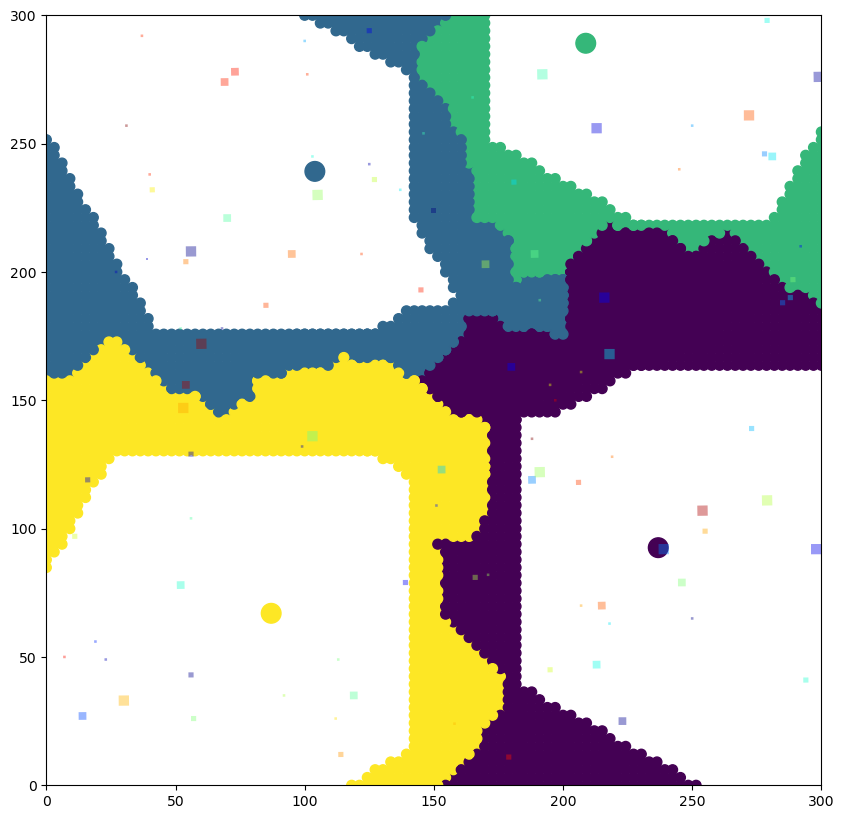

In [309]:
#plot qp
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#labels are z
labels =  z
plt_qp = qp.cpu().detach().numpy()
new_labels = F_ps.min(1)[1].cpu().detach().numpy()
ax.scatter(plt_qp[:,0], plt_qp[:,1], c=new_labels, s=50)
# plot best_outputs
plt_bo = best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:,0], plt_bo[:,1], c=c, s=200)
z_labels = z
pt.plot_data_on_manifold(fig, ax, sq,size=10, limits=[0,300,0,300])
#plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])
# plot p1 = 170,160



In [310]:
vor = Voronoi(4, 2, 2).to(device)
loss = nn.L1Loss()
qp = torch.tensor(qp)
optimizer = torch.optim.Adam(vor.parameters(), lr=1e-3)
epochs = 20000
squares, _ = loadData(100)
pseudo_clusters = []
for i in range(n_centroids):
    # append squares that their z_sq is i
    pseudo_clusters.append(squares[z_sq==i])
F_l = []
z_l = []
cost_l = []
cost_ll = []
qp = torch.tensor(qp).to(device)
outputs = torch.zeros(qp.shape[0], n_centroids)

ce = nn.CrossEntropyLoss()
acc_l = []
l_ce = []
es = []
best_vor_cost = torch.inf
best_vor_mode = None
for epoch in range(epochs):
    qp = torch.tensor(qp, dtype=torch.float32).to(device)
    # get outputs
    outputs = vor(qp)
    # pass outputs through a hard arg max
    F, z = outputs.min(1)
    F_ps_m, z_ps_m = F_ps.min(1)
    # send to device
    F_ps_m = F_ps_m.to(device)
    z_ps_m = z_ps_m.to(device)
    #make values of z_ps_m to be round to nearest integer
    r_z = torch.round(z_ps_m)
    # get loss
    alpha = 100
    beta = 1000
    z = z.float()
    z_ = outputs
    # make z_ float
    z_ = z_.float()
    z_cost = ce(z_, z_ps_m)
    F_cost = loss(F, F_ps_m)
    # get z_cost where we only penalize the wrong z and not its distance
    #z_cost = penalty(z, r_z)
    #F_l.append(F_cost.item())
    z_l.append(z_cost)
    #cost = alpha*F_cost + beta*z_cost
    cost = 10*z_cost 
    cost_l.append(cost.item())
    # backward
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if cost < best_vor_cost:
        best_vor_cost = cost
        best_vor_model = vor
    if epoch%2000==0:
        # lets check acc
        acc = 0
        for i in range(qp.shape[0]):
            F_e, z_e = outputs[i].max(0)
            if z_e == z_ps_m[i]:
                acc += 1
        acc_l.append(acc/qp.shape[0])
        es.append(epoch)
        cost_ll.append(cost.item())

        if epoch%200==0:
            print("Acc: ", acc/qp.shape[0])
            print("Epoch: ", epoch, "Cost: ", cost.item())

C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\209586782.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp)
C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\209586782.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp).to(device)
C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_15528\209586782.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp, dtype=torch.float32).to(device)


Loading data...
Data loaded.
Acc:  0.26474010861132663
Epoch:  0 Cost:  85.12348937988281
Acc:  0.851823118696664
Epoch:  2000 Cost:  3.563750743865967
Acc:  0.8974010861132661
Epoch:  4000 Cost:  2.412677526473999
Acc:  0.9059348332040341
Epoch:  6000 Cost:  2.010458469390869
Acc:  0.9550038789759504
Epoch:  8000 Cost:  1.2973239421844482
Acc:  0.9573312645461598
Epoch:  10000 Cost:  1.159397006034851
Acc:  0.9189294026377036
Epoch:  12000 Cost:  1.532714605331421
Acc:  0.9796353762606672
Epoch:  14000 Cost:  0.8953274488449097
Acc:  0.869278510473235
Epoch:  16000 Cost:  2.9320132732391357
Acc:  0.9154383242823895
Epoch:  18000 Cost:  1.7684621810913086


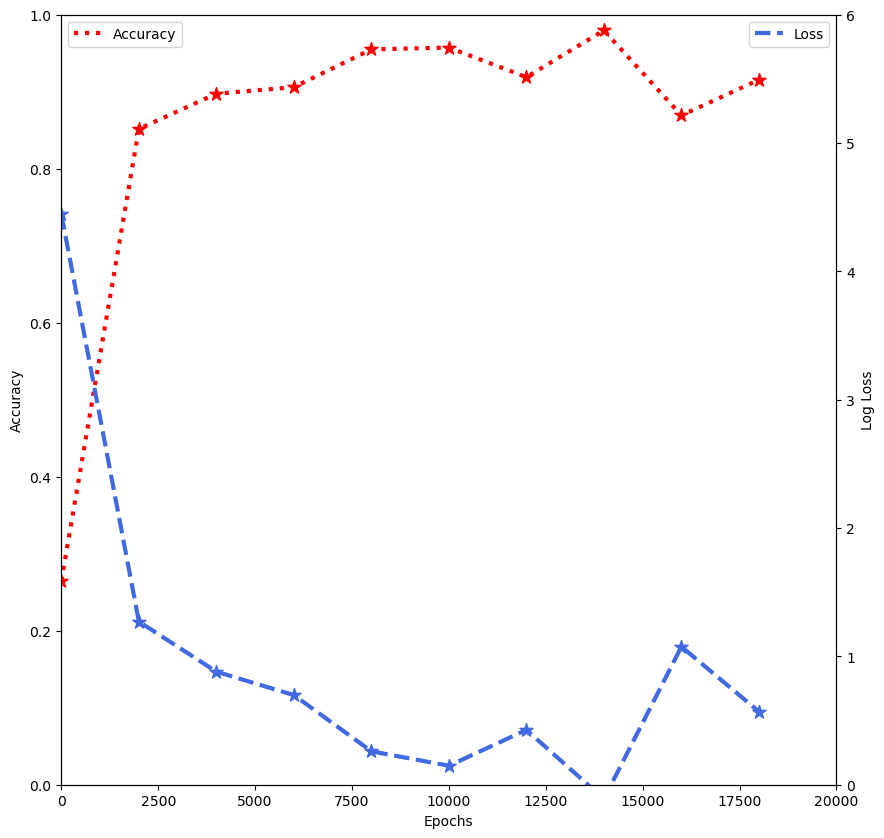

In [311]:
# plot acc_l in right axis and l_ce in left axis
# make cost_ll log
cost_ll_log = np.log(cost_ll)
    
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(es,acc_l, c='r', label='Accuracy', linestyle='dotted',linewidth=3)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')
ax1.set_ylim([0, 1])
ax2 = ax1.twinx()
ax2.plot(es,cost_ll_log, c='royalblue', label='Loss', linestyle='dashed',linewidth=3)
ax2.set_ylabel('Log Loss')
ax2.legend(loc='upper right')
ax2.set_ylim([0, 6])
# set x_lim in both
ax1.set_xlim([0, epochs])
ax2.set_xlim([0, epochs])
# add stars to the plot points
ax1.scatter(es,acc_l, c='r', s=100, marker='*')
ax2.scatter(es,cost_ll_log, c='royalblue', s=100, marker='*')

In [313]:
best_vor_cost

tensor(0.6828, device='cuda:0', grad_fn=<MulBackward0>)

In [264]:
vor =Voronoi(4, 2, 2).to(device)

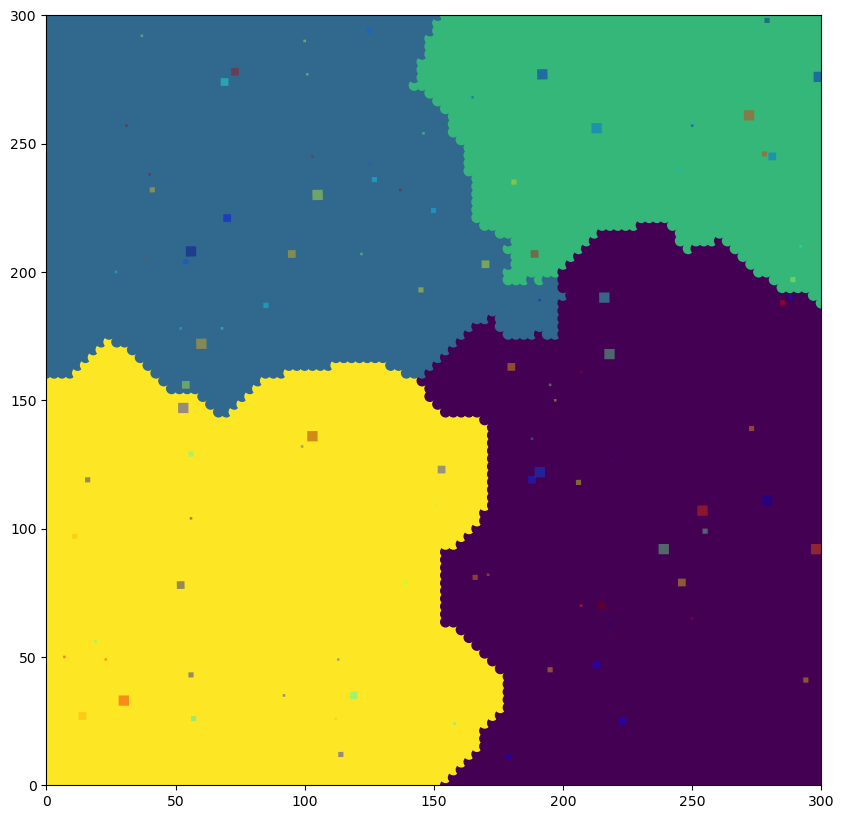

In [388]:
# ok lets infer
infer_points = torch.zeros(10000, 2)
x_lim = [0,300]
y_lim = [0,300]
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], 100)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], 100)):
        infer_points[i*100+j] = torch.Tensor([x, y])
        

infer_points = infer_points.to(device)

classes = best_vor_model(infer_points)
infer_points = infer_points.cpu().detach().numpy()
classes = classes.max(1)[-1].cpu().detach().numpy()
# plot classes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#manifold_plot = manifold_plot.cpu().detach().numpy()
ax.scatter(infer_points[:,0], infer_points[:,1], c=classes, s=50)
#ax.contourf(manifold1[:,:,0], manifold1[:,:,1], classes, levels=level, cmap='viridis', alpha=0.9)
# plot scatter of output = model(model.z)
pt.plot_data_on_manifold(fig, ax, sq,size=10, limits=[0,300,0,300])

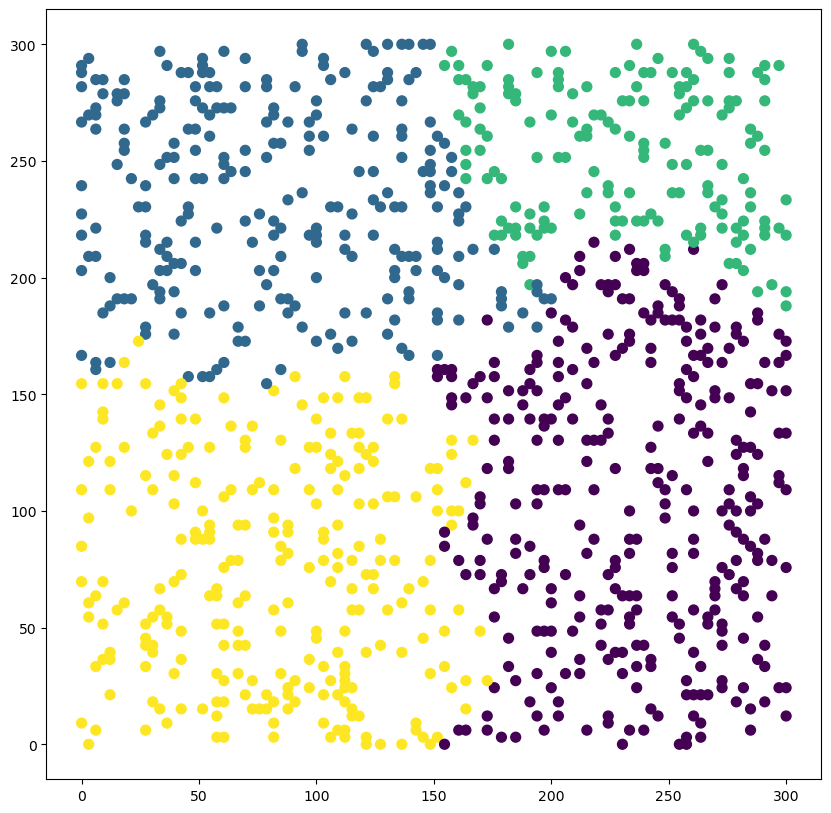

In [389]:
# take 10000 points randomly in [0,300]x[0,300]
random_p = torch.zeros(10000, 2)
x_lim = [0,300]
y_lim = [0,300]
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], 100)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], 100)):
        random_p[i*100+j] = torch.Tensor([x, y])

infer_points = random_p.to(device)
# take 5000 randomly of those
infer_points = random_p[torch.randperm(random_p.shape[0])][:1000]
# =
infer_points = infer_points.to(device)
classes = best_vor_model(infer_points)
z = classes.max(1)[-1].cpu().detach().numpy()
infer_points = infer_points.cpu().detach().numpy()
# plot infer_points
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(infer_points[:,0], infer_points[:,1], c=z, s=50)

In [390]:
# randomly infered points
#infer_points = torch.randn(10000, 2)
# they must be in [0,300]x[0,300]
#infer_points = infer_points*150 + 150
n = 0
outputs = torch.zeros(infer_points.shape[0], n_centroids)
F_ps_infer = torch.zeros(outputs.shape[0], outputs.shape[1])
z_ps_infer = torch.zeros(outputs.shape[0], outputs.shape[1])
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        qpoint = infer_points[i]
        F_ps_infer[i,j], z_ps_infer[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))
    if n%1000 == 0:
        print(n)
    n += 1
z_i = F_ps_infer.min(1)[1].cpu().detach().numpy()

0


In [391]:
# get all the number of times z == z_i
#z = z.cpu().detach().numpy()
#z_i = z_i.detach().numpy()
#times = [classes==z_i]
times = [z==z_i]
print(np.sum(times)/z.shape[0])
print("Number of false predictions: ", z.shape[0] - np.sum(times))

0.996
Number of false predictions:  4


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

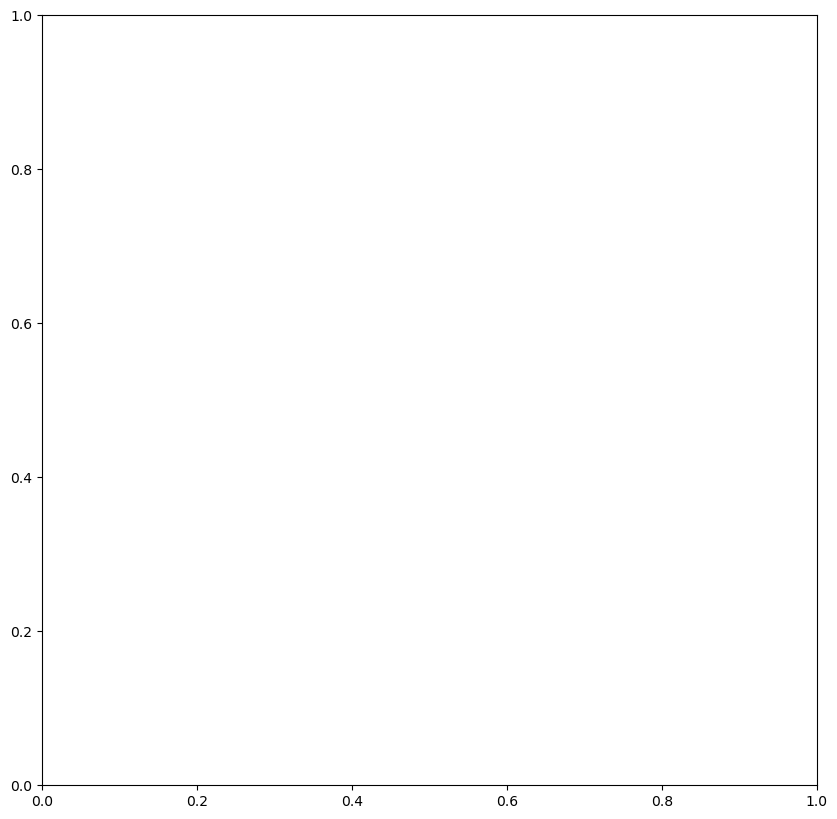

In [378]:
# plot points
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
infer_points_plt = infer_points
z = z
ax.scatter(infer_points_plt[:,0], infer_points_plt[:,1], c=classes, s=50, label='Predictions', alpha=0.8)
# plot z_i labels
# color
ax.scatter(infer_points_plt[:,0], infer_points_plt[:,1], c=z_i, s=1, label='True Labels', alpha=0.8)
ax.set_xlim([0,300])
ax.set_ylim([0,300])
# plot legend
plt.legend(scatterpoints=1, loc='upper left', fontsize=10)
# also vis data
pt.plot_data_on_manifold(fig, ax, sq,size=10, limits=[0,300,0,300])
# plot best_outputs
plt_bo = best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:,0], plt_bo[:,1], c=c, s=200)

